In [118]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression

from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

In [119]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [120]:
df= pd.read_csv('./solarpowergeneration.csv')

In [121]:
df.head()

,distance-to-solar-noon,temperature,wind-direction,wind-speed,sky-cover,visibility,humidity,average-wind-speed-(period),average-pressure-(period),power-generated
0,0.859897,69,28,7.5,0,10.0,75,8.0,29.82,0
1,0.628535,69,28,7.5,0,10.0,77,5.0,29.85,0
2,0.397172,69,28,7.5,0,10.0,70,0.0,29.89,5418
3,0.165810,69,28,7.5,0,10.0,33,0.0,29.91,25477
4,0.065553,69,28,7.5,0,10.0,21,3.0,29.89,30069


In [122]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2920 entries, 0 to 2919
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   distance-to-solar-noon       2920 non-null   float64
 1   temperature                  2920 non-null   int64  
 2   wind-direction               2920 non-null   int64  
 3   wind-speed                   2920 non-null   float64
 4   sky-cover                    2920 non-null   int64  
 5   visibility                   2920 non-null   float64
 6   humidity                     2920 non-null   int64  
 7   average-wind-speed-(period)  2919 non-null   float64
 8   average-pressure-(period)    2920 non-null   float64
 9   power-generated              2920 non-null   int64  
dtypes: float64(5), int64(5)
memory usage: 228.2 KB


In [123]:
df.describe()

,distance-to-solar-noon,temperature,wind-direction,wind-speed,sky-cover,visibility,humidity,average-wind-speed-(period),average-pressure-(period),power-generated
count,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2919.000000,2920.000000,2920.000000
mean,0.503294,58.468493,24.953425,10.096986,1.987671,9.557705,73.513699,10.129154,30.017760,6979.846233
std,0.298024,6.841200,6.915178,4.838185,1.411978,1.383884,15.077139,7.261547,0.142006,10312.336413
min,0.050401,42.000000,1.000000,1.100000,0.000000,0.000000,14.000000,0.000000,29.480000,0.000000
25%,0.243714,53.000000,25.000000,6.600000,1.000000,10.000000,65.000000,5.000000,29.920000,0.000000
50%,0.478957,59.000000,27.000000,10.000000,2.000000,10.000000,77.000000,9.000000,30.000000,404.000000
75%,0.739528,63.000000,29.000000,13.100000,3.000000,10.000000,84.000000,15.000000,30.110000,12723.500000
max,1.141361,78.000000,36.000000,26.600000,4.000000,10.000000,100.000000,40.000000,30.530000,36580.000000


In [124]:
mask2 = np.triu(np.ones_like(df.corr(), dtype=bool))

In [125]:
X =  df.drop(['power-generated'], axis=1)
y= df['power-generated']

X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                                random_state=0)

# "Cardinality" means the number of unique values in a column
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
categorical_cols = [cname for cname in X_train_full.columns if X_train_full[cname].nunique() < 10 and 
                        X_train_full[cname].dtype == "object"]

# Select numerical columns
numerical_cols = [cname for cname in X_train_full.columns if X_train_full[cname].dtype in ['int64', 'float64']]

# Keep selected columns only
my_cols = categorical_cols + numerical_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()

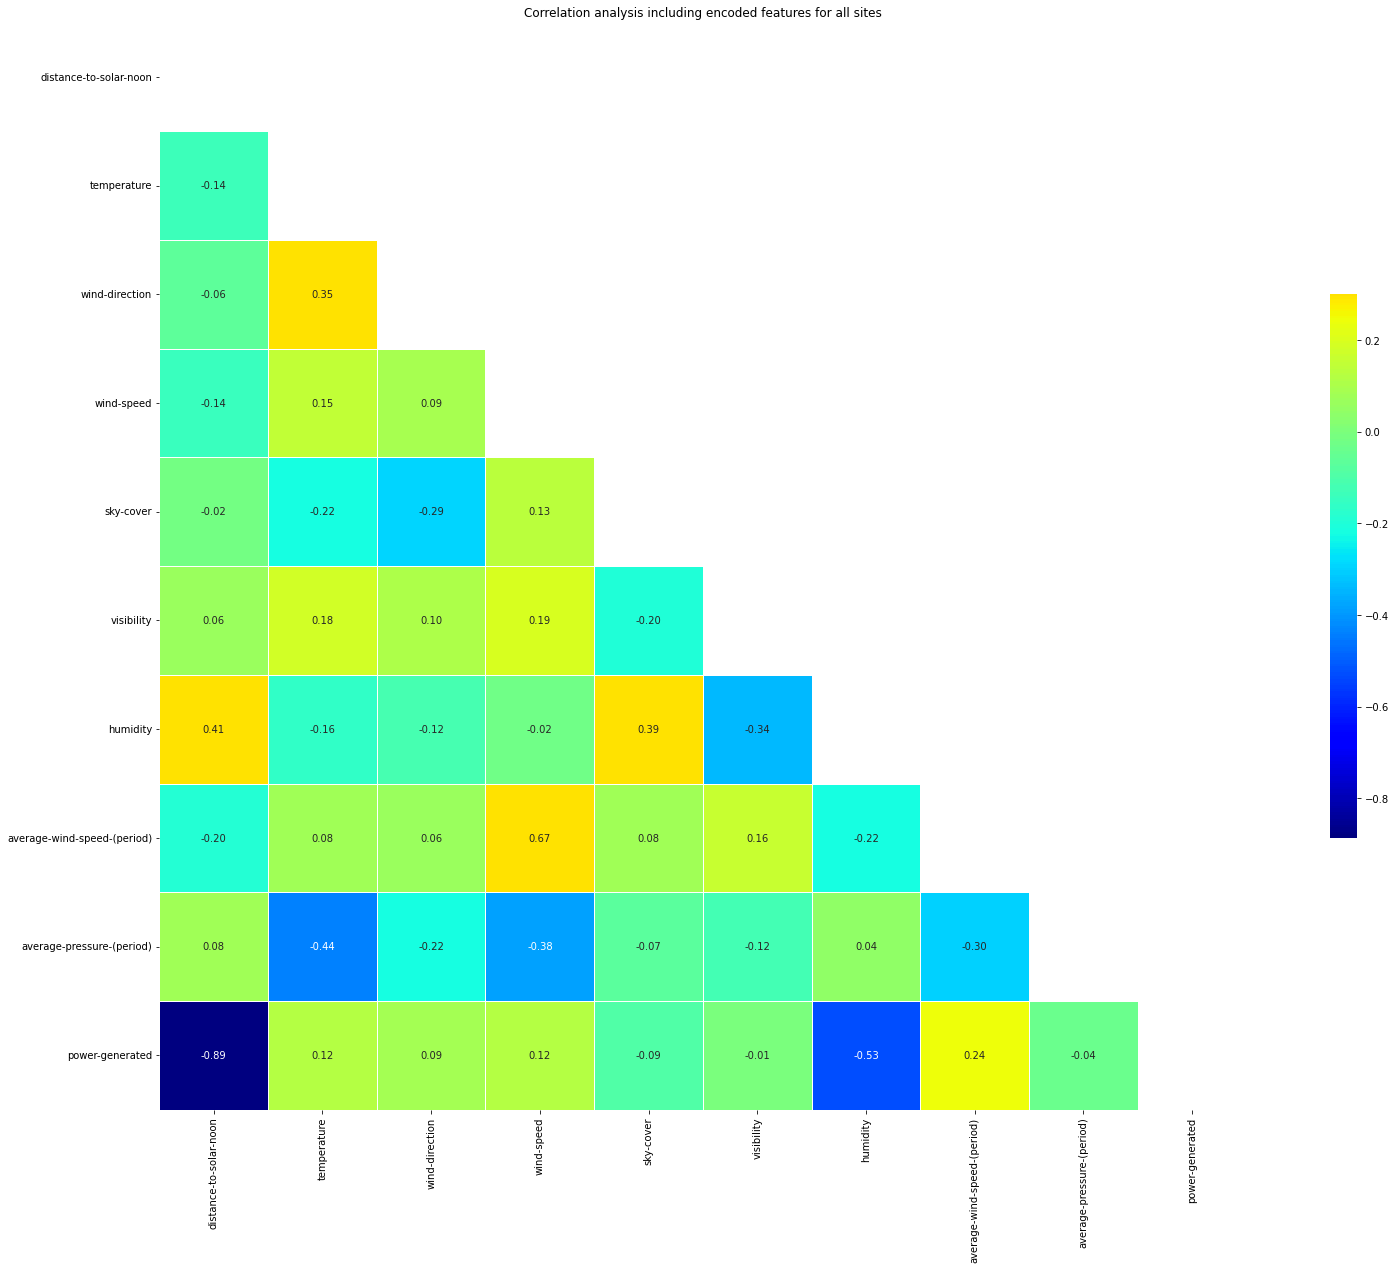

In [126]:
f, ax = plt.subplots(figsize=(30, 20))
sns.heatmap(df.corr(method='spearman'), mask=mask2, cmap='jet', vmax=.3, center=0, annot=True, fmt='.2f',
            square=True, linewidths=.9, cbar_kws={"shrink": .5});
plt.title('Correlation analysis including encoded features for all sites');

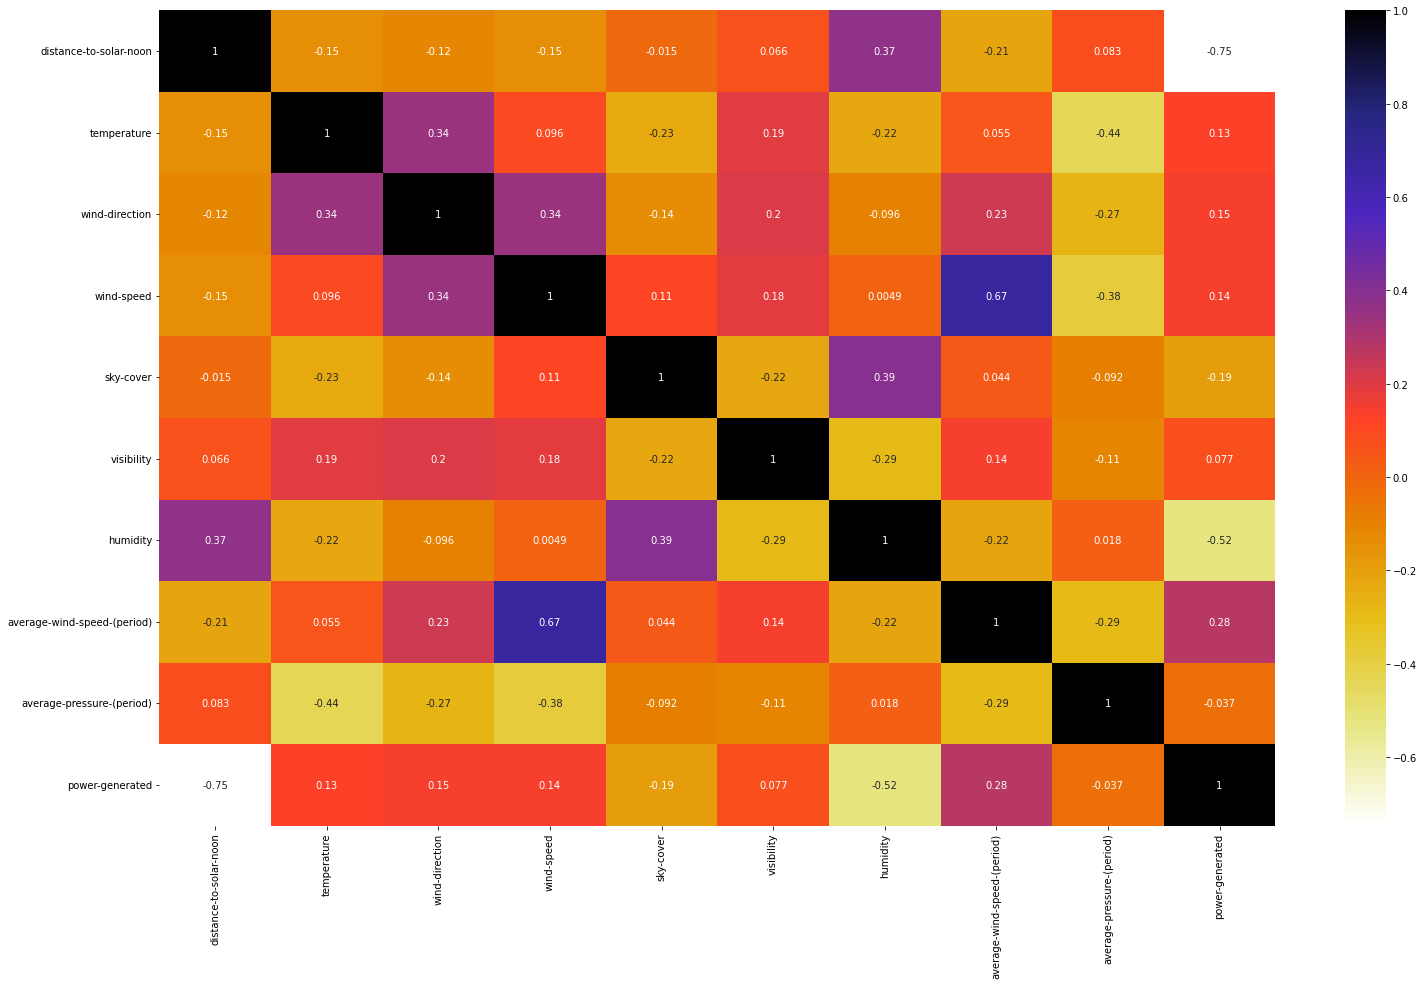

In [127]:
plt.figure(figsize=(25,15))
cor=df.corr()
sns.heatmap(cor,annot=True, cmap=plt.cm.CMRmap_r)
plt.show()

In [128]:
def correlation(dataset, threshold):
    col_corr = set()
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i,j]) > threshold:
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
    return col_corr

In [129]:
corr_features = correlation(X_train, 0.3)
len(set(corr_features))

5

In [130]:
corr_features =  list(corr_features)
corr_features

['average-pressure-(period)',
 'wind-speed',
 'wind-direction',
 'average-wind-speed-(period)',
 'humidity']

In [171]:
# X_train.drop(corr_features, axis=1)
# X_valid.drop(corr_features, axis=1)

In [238]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='constant')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [239]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, random_state=0)

In [256]:
from sklearn.metrics import mean_absolute_error

# Bundle preprocessing and modeling code in a pipeline
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)
                             ])

# Preprocessing of training data, fit model 
my_pipeline.fit(X_valid, y_valid)

# Preprocessing of validation data, get predictions
preds = my_pipeline.predict(X_valid)

# Evaluate the model
score = mean_absolute_error(y_valid, preds)
print('MAE:', score)

MAE: 487.5432876712329


In [257]:
from sklearn.model_selection import cross_val_score

# Multiply by -1 since sklearn calculates *negative* MAE
scores = -1 * cross_val_score(my_pipeline, X_valid, y_valid,
                              cv=5,
                              scoring='neg_mean_absolute_error')

print("MAE scores:\n", scores)
print("Average MAE score (across experiments):")
print(scores.mean())

MAE scores:
 [1384.3691453  1632.40666667 2215.1617094  1288.79068376 1563.14163793]
Average MAE score (across experiments):
1616.7739686118484


Text(0, 0.5, 'Predicted Y')

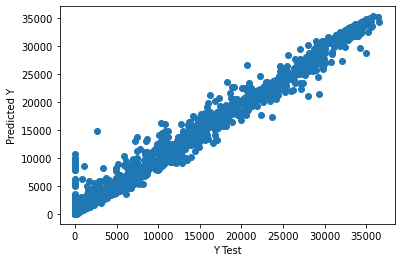

In [258]:

predictions = my_pipeline.predict(X)
plt.scatter(y, predictions)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')

In [259]:
from sklearn import metrics

print('MAE:', metrics.mean_absolute_error(y, predictions))
print('MSE:', metrics.mean_squared_error(y, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y, predictions)))
print("R2 Score: ", my_pipeline.score(X, y))

MAE: 535.9955547945206
MSE: 1379684.5692811643
RMSE: 1174.599748544654
R2 Score:  0.9870218013040818


In [260]:
from xgboost import XGBRegressor

xg_boost = XGBRegressor(n_estimators=10000, learning_rate=0.005, n_jobs=100)
xg_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', xg_boost)
                             ])

# Preprocessing of training data, fit model 
xg_pipeline.fit(X_valid, y_valid)

# Preprocessing of validation data, get predictions
xg_preds = xg_pipeline.predict(X_valid)

In [261]:
from sklearn.model_selection import cross_val_score

# Multiply by -1 since sklearn calculates *negative* MAE
xg_scores = -1 * cross_val_score(xg_pipeline, X_valid, y_valid,
                              cv=5,
                              scoring='neg_mean_absolute_error')

print("MAE scores:\n", xg_scores)
print("Average MAE score (across experiments):")
print(xg_scores.mean())

MAE scores:
 [1213.7324232  1654.62917015 2364.08537841 1274.97149811 1564.52981118]
Average MAE score (across experiments):
1614.3896562082678


Text(0, 0.5, 'Predicted Y')

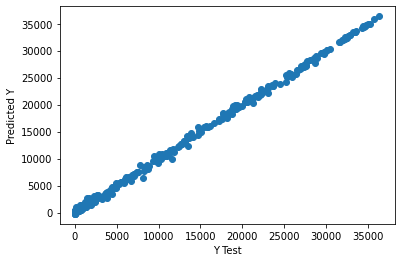

In [265]:
predictions = xg_pipeline.predict(X_valid)
plt.scatter(y_valid, predictions)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')

In [267]:
from sklearn import metrics

print('MAE:', metrics.mean_absolute_error(y_valid, predictions))
print('MSE:', metrics.mean_squared_error(y_valid, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_valid, predictions)))
print("R2 Score: ", xg_pipeline.score(X_valid, y_valid))

MAE: 156.14051386267457
MSE: 77289.34580228264
RMSE: 278.00961458604746
R2 Score:  0.9992741202215983


In [264]:
predictions = model.predict(X_valid)
print(f"True output: {y_valid.values[4]}")
print(f"Predicted output: {predictions[4]}")
print(f"Prediction Error: {(predictions[4] - y_valid.values[4])/ y_valid.values[4] * 100}%")

True output: 455
Predicted output: 485.58
Prediction Error: 6.7208791208791165%


c:\Users\Admin\Desktop\school\sst\solar-energy-predictions\env\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


In [268]:
# # export the model
# import pickle
# with open("model_pickle", "wb") as f:
#     pickle.dump(model, f)

In [272]:
# # test import
import pickle
with open('model_pickle', "rb") as f:
    imported_model = pickle.load(f)

c:\Users\Admin\Desktop\school\sst\solar-energy-predictions\env\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


Text(0, 0.5, 'Predicted Y')

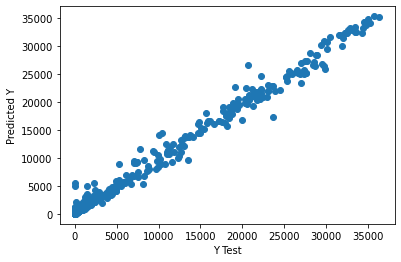

In [273]:
im_predictions = imported_model.predict(X_valid)
plt.scatter(y_valid, im_predictions)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')

In [274]:
print('MAE:', metrics.mean_absolute_error(y_valid, im_predictions))
print('MSE:', metrics.mean_squared_error(y_valid, im_predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_valid, im_predictions)))
print("R2 Score: ", imported_model.score(X_valid, y_valid))

MAE: 487.5432876712329
MSE: 992686.9442256849
RMSE: 996.3367624581986
R2 Score:  0.9906769636666344


c:\Users\Admin\Desktop\school\sst\solar-energy-predictions\env\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
